In [1]:
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
from procgen import ProcgenGym3Env
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv

%load_ext autoreload
%autoreload 2

In [17]:

env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 

model = load_model()

In [2]:
class ModelActivations:
    def __init__(self, model):
        self.activations = {}
        self.model = model
        self.hooks = []  # To keep track of hooks

    def clear_hooks(self):
        # Remove all previously registered hooks
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}

    def get_activation(self, name):
        def hook(model, input, output):
            processed_output = []
            for item in output:
                if isinstance(item, torch.Tensor):
                    processed_output.append(item.detach())
                elif isinstance(item, torch.distributions.Categorical):
                    processed_output.append(item.logits.detach())
                else:
                    processed_output.append(item)
            self.activations[name] = tuple(processed_output)
        return hook

    def register_hook_by_path(self, path, name):
        elements = path.split('.')
        model = self.model
        for i, element in enumerate(elements):
            if '[' in element:
                base, index = element.replace(']', '').split('[')
                index = int(index)
                model = getattr(model, base)[index]
            else:
                model = getattr(model, element)
            if i == len(elements) - 1:
                hook = model.register_forward_hook(self.get_activation(name))
                self.hooks.append(hook)  # Keep track of the hook

    def run_with_cache(self, input, layer_paths):
        self.clear_hooks()  # Clear any existing hooks
        self.activations = {}  # Reset activations

        # Handle edge case: input is not a tensor
        if not isinstance(input, torch.Tensor):
            input = torch.tensor(input, dtype=torch.float32)


        # Check the shape of the input and reshape if necessary
        if input.shape == torch.Size([1, 3, 64, 64]):
            input = input.squeeze(0)  # Remove the batch dimension
        if input.shape == torch.Size([3, 64, 64]):
            input = input.permute(1, 2, 0)  # Switch dimensions to (64, 64, 3)


        # Handle edge case: empty layer_paths
        if not layer_paths:
            output = self.model(input)
            return output, self.activations

        # Register hooks for each layer path
        for path in layer_paths:
            try:
                self.register_hook_by_path(path, path.replace('.', '_'))
            except AttributeError:
                print(f"Warning: Layer '{path}' not found in the model. Skipping hook registration.")

        print(input.shape)

        # Add batch dimension if missing
        if input.dim() == 3:
            input = input.unsqueeze(0)

        # Run the model with the registered hooks
        output = self.model(input)

        return output, self.activations

model_activations = ModelActivations(model)
model_activations.clear_hooks()


NameError: name 'model' is not defined

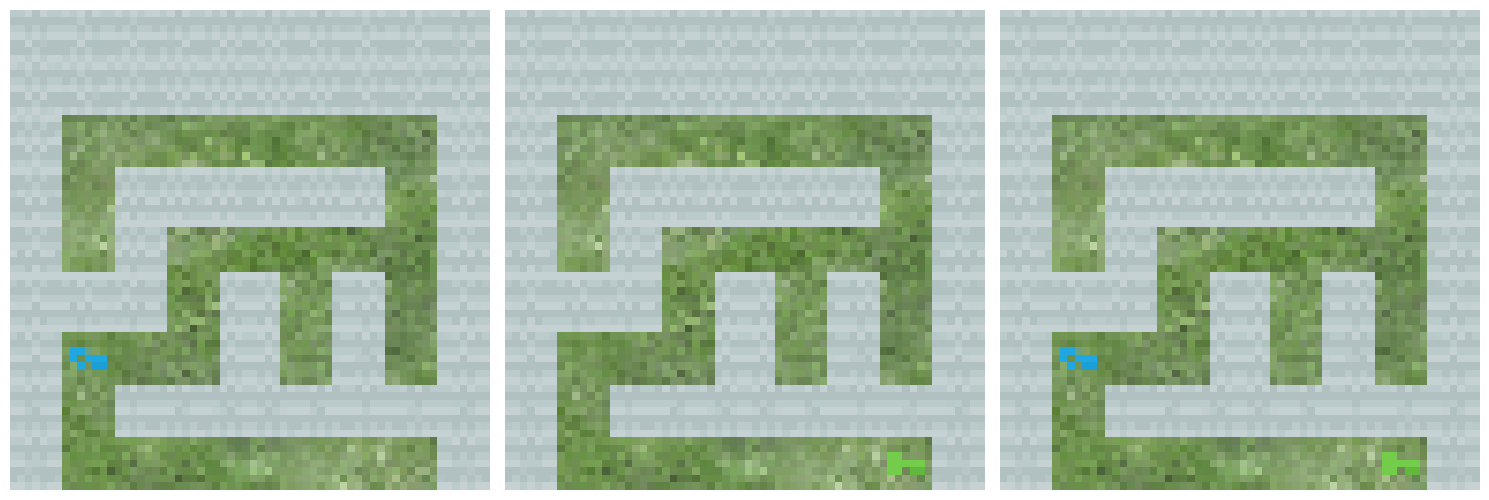

In [ ]:
num_samples = 1
num_levels = 100
key_color_combinations = [['blue'], ['green'], ['blue', 'green']]
observations_list = heist.create_key_states(key_color_combinations, num_samples, num_levels)


import itertools
fig, axs = plt.subplots(1, 3, figsize=(15, 12))  # Adjusted to create a 5x3 grid
for ( j), obs in zip(itertools.product(range(3)), itertools.chain.from_iterable(observations_list)):
    axs[ j].imshow(obs.transpose(1, 2, 0))
    # axs[i, j].set_title(f"Sample {j+1}, Obs {i+1}")
    axs[j].axis('off')
plt.tight_layout()
plt.show()

In [36]:
observations_list[0][0].shape

(3, 64, 64)

In [44]:
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]

In [45]:

blue_key_only = observations_list[0][0]
green_key_only = observations_list[0][1]
blue_and_green_key = observations_list[0][2]

obs1 = torch.tensor(blue_key_only, dtype=torch.float32)
obs2 = torch.tensor(blue_and_green_key, dtype=torch.float32)

output1, blue_key_only_activations = model_activations.run_with_cache(obs1, layer_paths)
model_activations.clear_hooks()
output2, blue_and_green_key_activations = model_activations.run_with_cache(obs2, layer_paths)



torch.Size([64, 64, 3])
torch.Size([64, 64, 3])


In [39]:
differences = helpers.compute_activation_differences(blue_and_green_key_activations,blue_key_only_activations)
layer_paths = differences.keys()
print(layer_paths)

helpers.plot_activations_for_layers(differences, ['conv_seqs_0_res_block0_conv0'])

{}
dict_keys([])
No activations found for layer: conv_seqs_0_res_block0_conv0


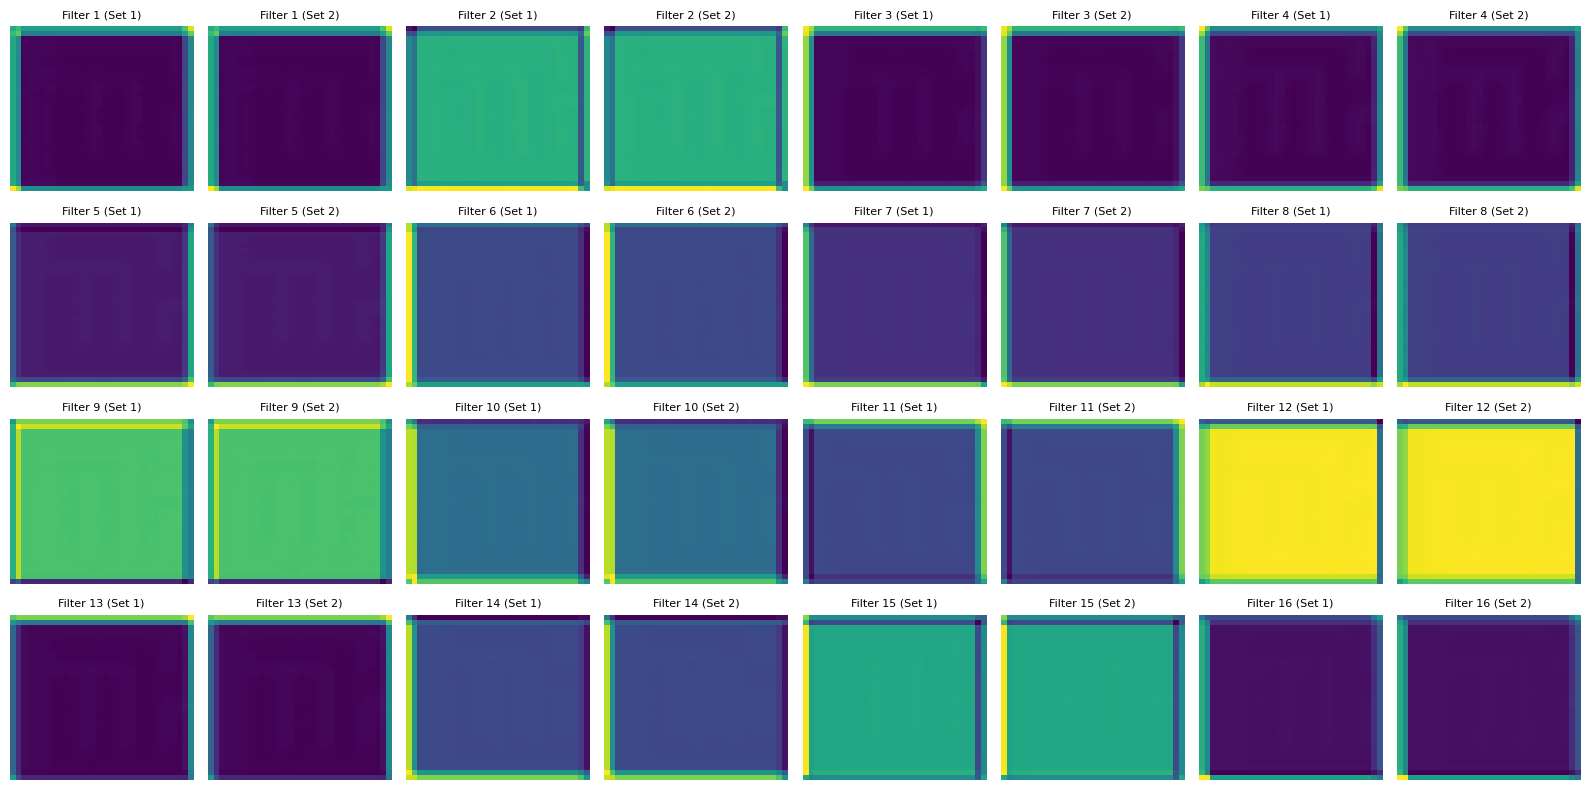

In [25]:
all_layers = ['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1']
later_layers=[    
   'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1']

helpers.plot_activations_for_layers_side_by_side(blue_and_green_key_activations,blue_key_only_activations, ['conv_seqs_0_res_block0_conv1'])

In [142]:
def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False, episode_timeout=200):

    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames=[]
    
    

    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        action = generate_action(model, observation, is_procgen_env=True) 
        
        observation, reward, done, info = env.step(action)
        total_reward += reward
        observations.append(observation)
        count +=1
        if count >= episode_timeout:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames, observations




In [145]:
save_gif_option = True  
for episode in range(1):
    venv = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
    total_reward, frames, observations = run_episode_and_save_as_gif(venv, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")

TypeError: generate_action() got an unexpected keyword argument 'is_procgen_env'

In [47]:
observation = torch.tensor(observations[0], dtype=torch.float32).unsqueeze(0)
output1, normal_activations = model_activations.run_with_cache(observation, layer_paths)

torch.Size([1, 64, 64, 3])


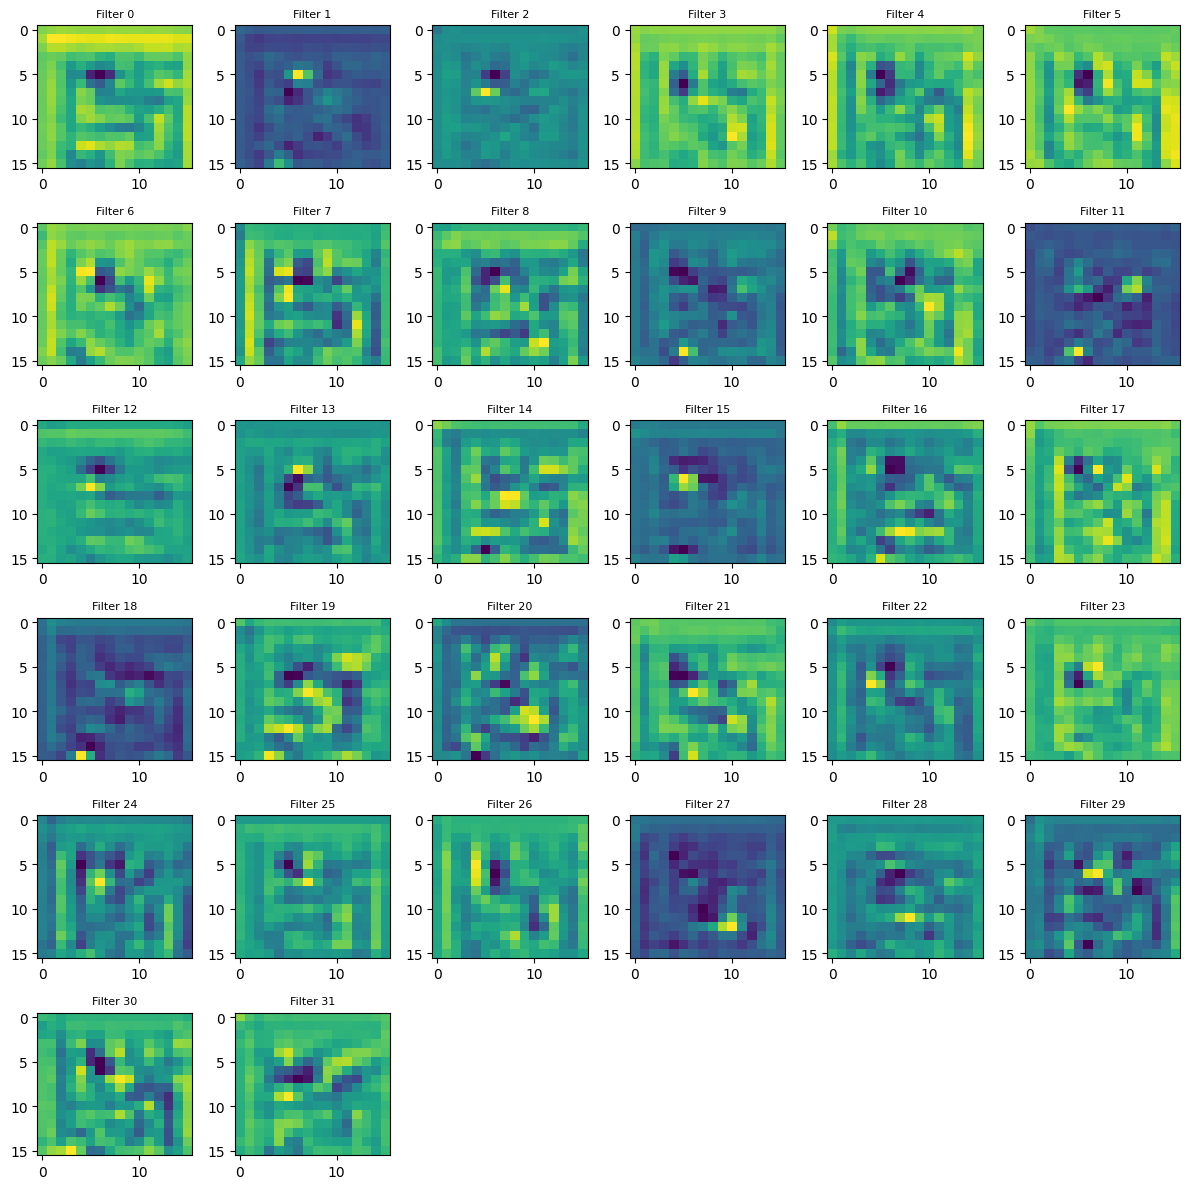

In [52]:
helpers.plot_layer_activations_dynamic_grid(normal_activations, "conv_seqs_2_conv")

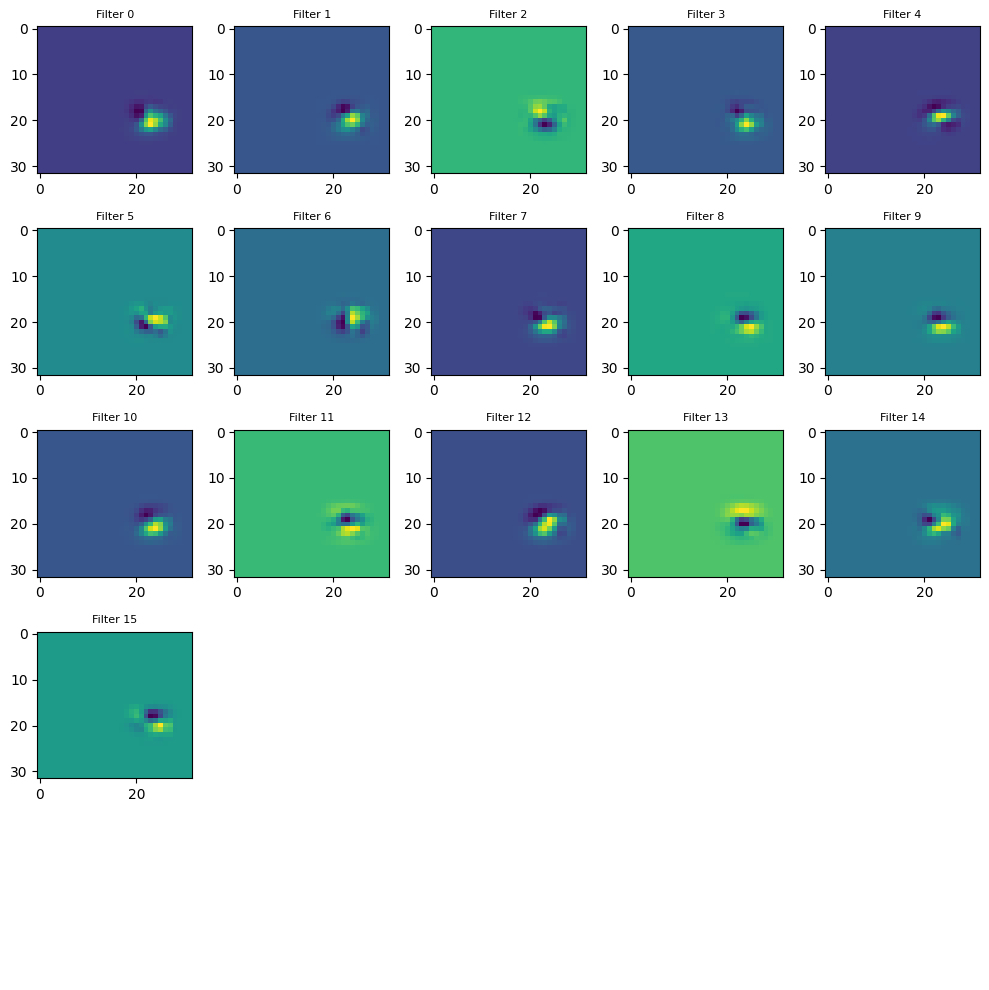

In [ ]:
helpers.plot_layer_activations_dynamic_grid(differences, "conv_seqs_0_res_block1_conv1")


In [62]:
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)

full_grid = state.full_grid(with_mouse=False)
entities = state.state_vals["ents"]
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()


state.remove_all_entities()

x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
entities = state.state_vals["ents"]
# state.set_key_position(0,x,y) 
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_mouse_pos(x,y)
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_gem_position(x,y)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()

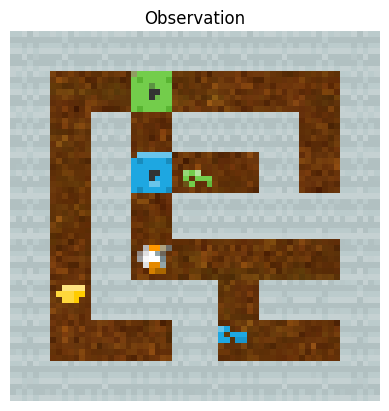

In [81]:
helpers.plot_single_observation(gym_obs.squeeze().transpose(1,0,2))

In [110]:
gym_obs

array([[[187, 203, 204],
        [187, 203, 204],
        [197, 209, 210],
        ...,
        [197, 209, 210],
        [187, 203, 204],
        [187, 203, 204]],

       [[177, 192, 193],
        [177, 192, 193],
        [177, 192, 193],
        ...,
        [177, 192, 193],
        [177, 192, 193],
        [177, 192, 193]],

       [[187, 203, 204],
        [187, 203, 204],
        [177, 192, 193],
        ...,
        [177, 192, 193],
        [187, 203, 204],
        [187, 203, 204]],

       ...,

       [[177, 192, 193],
        [177, 192, 193],
        [184, 198, 199],
        ...,
        [184, 198, 199],
        [177, 192, 193],
        [177, 192, 193]],

       [[177, 192, 193],
        [187, 203, 204],
        [177, 192, 193],
        ...,
        [177, 192, 193],
        [186, 202, 203],
        [177, 192, 193]],

       [[197, 209, 210],
        [197, 209, 210],
        [187, 203, 204],
        ...,
        [187, 203, 204],
        [197, 209, 210],
        [197, 209, 210]]

In [122]:
output2, player_blue_key_activations = model_activations.run_with_cache(obs, layer_paths)
output2, unmodified_activations = model_activations.run_with_cache(unchanged_obs, layer_paths)
output2, gym_activations = model_activations.run_with_cache(gym_obs, layer_paths)
output2, gym_activations_test = model_activations.run_with_cache(test_obs, layer_paths)
output2, shifted_obs_activations = model_activations.run_with_cache(shifted_obs, layer_paths)


torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])


In [ ]:
player_blue_key_activations.keys()

dict_keys(['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1'])

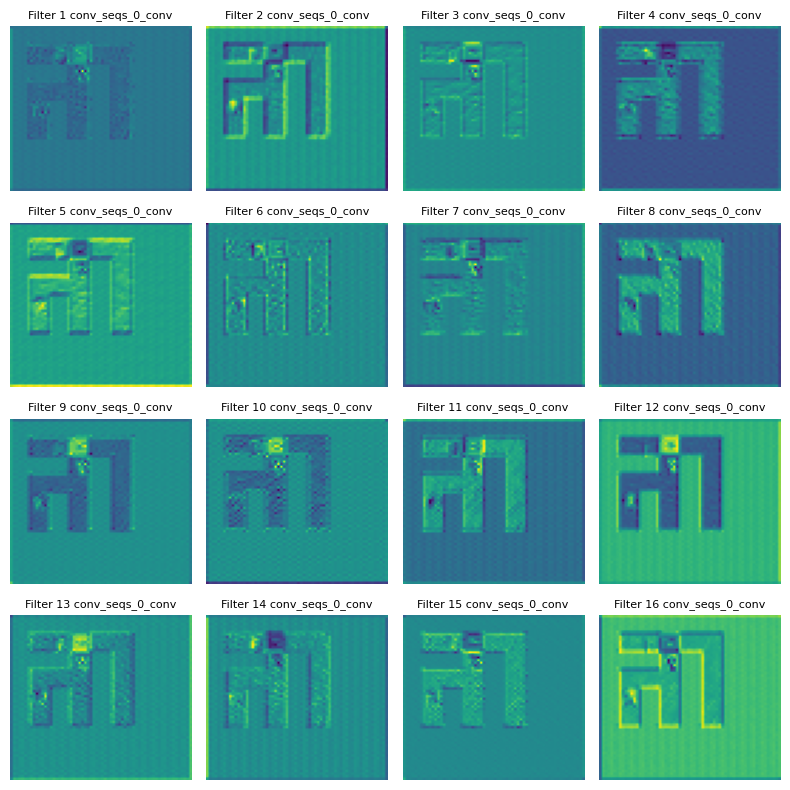

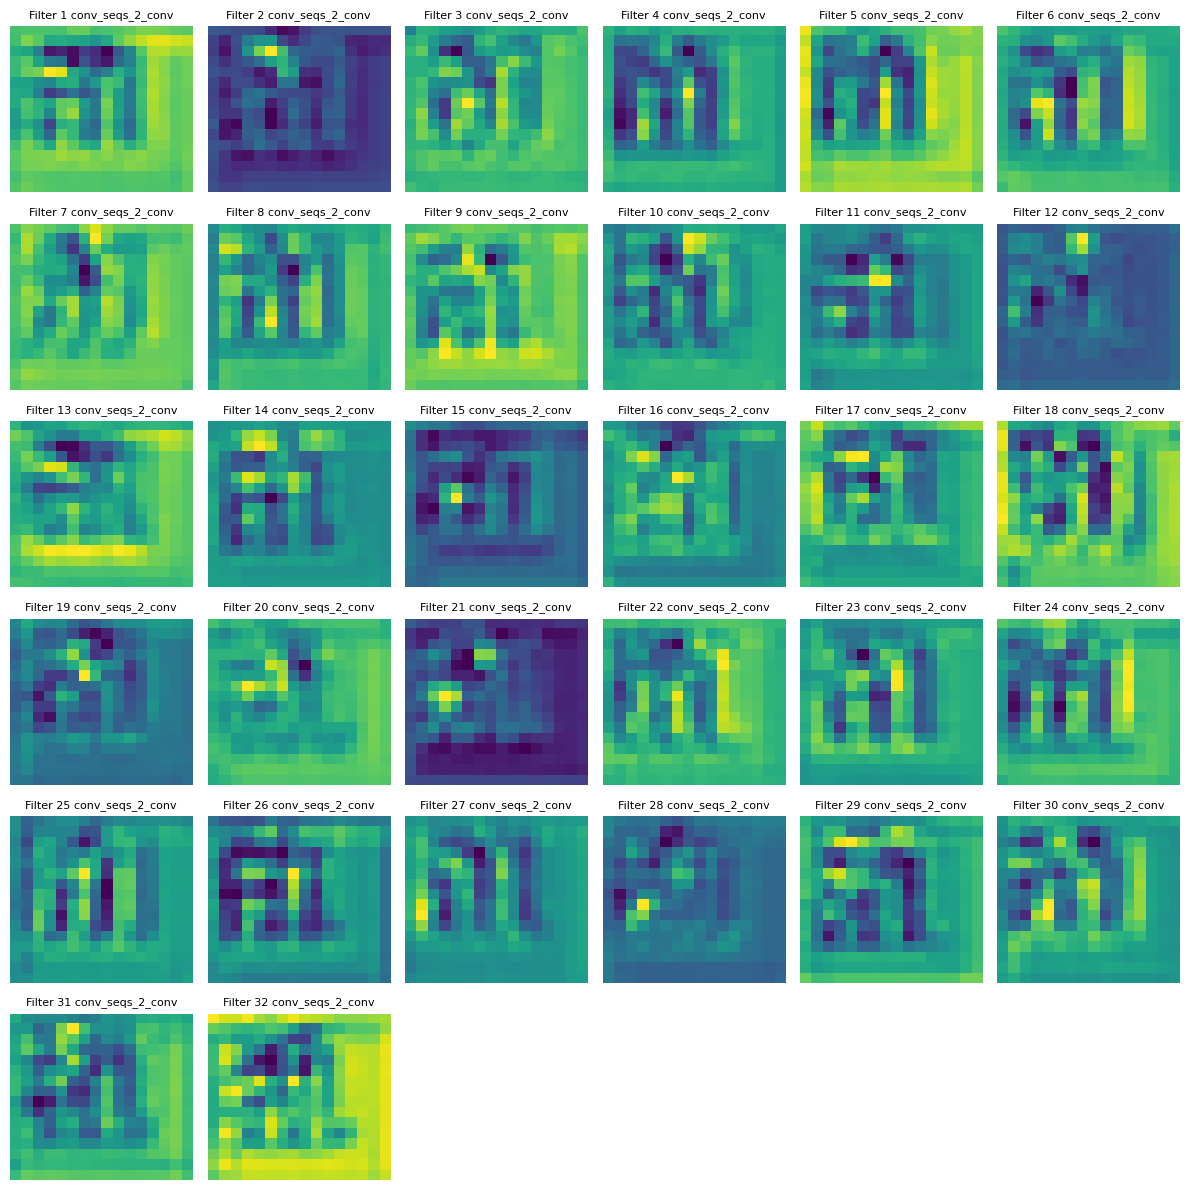

In [124]:
helpers.plot_activations_for_layers(shifted_obs_activations, ["conv_seqs_0_conv", "conv_seqs_2_conv"] )

torch.Size([64, 64, 3])


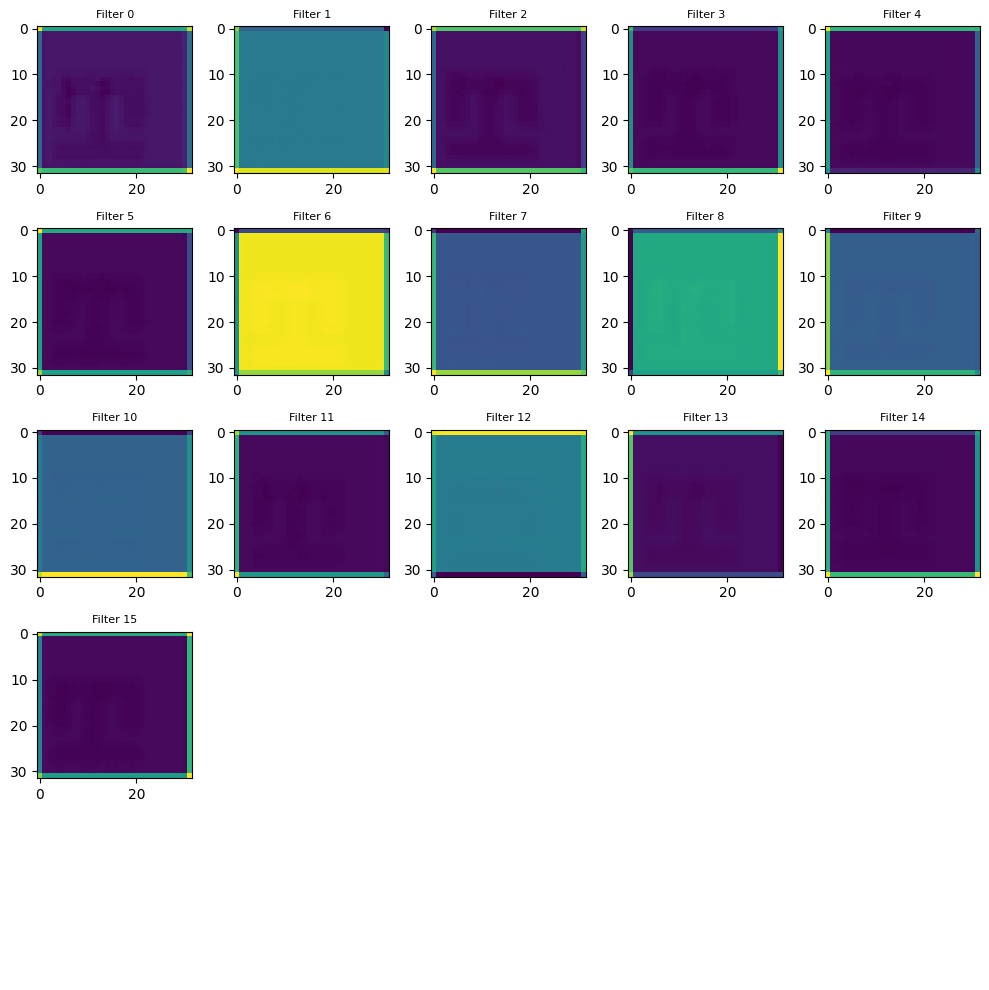

In [ ]:
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)
normal_obs = venv.reset()
output2, normal_activations = model_activations.run_with_cache(normal_obs, layer_paths)
helpers.plot_layer_activations_dynamic_grid(normal_activations, "conv_seqs_0_res_block0_conv0")

In [ ]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Initialize a placeholder for processed output
        processed_output = []
        
        for item in output:
            # Check if the item is a tensor and detach it
            if isinstance(item, torch.Tensor):
                processed_output.append(item.detach())
            # If the item is a Categorical, you might want to extract its logits or probs
            elif isinstance(item, torch.distributions.Categorical):
                processed_output.append(item.logits.detach())
            else:
                # Handle other types as necessary
                processed_output.append(item)
        
        # Save the processed output in the activations dictionary
        activations[name] = tuple(processed_output)
    return hook



# Define a function to recursively register hooks based on a path
def register_hook_by_path(model, path, name):
    elements = path.split('.')
    for i, element in enumerate(elements):
        if '[' in element:
            # Splitting at '[' and removing the closing ']' to get the index
            base, index = element.replace(']', '').split('[')
            index = int(index)  # Convert index to integer
            model = getattr(model, base)[index]
        else:
            model = getattr(model, element)
        # If we are at the last element, register the hook
        if i == len(elements) - 1:
            model.register_forward_hook(get_activation(name))

# List of layer paths to hook, based on your initial list
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]


# Register hooks for each path
for path in layer_paths:
    register_hook_by_path(model, path, path.replace('.', '_'))


observation = torch.tensor(normal_obs, dtype=torch.float32)


# if observation.shape == torch.Size([3, 64, 64]):
observation = observation.permute(0,3, 2, 1)  # Switch dimensions to (64, 64, 3)

output = model(observation)


In [ ]:
observation_test = torch.tensor(observations[0], dtype=torch.float32).unsqueeze(0)
observation_test.shape

torch.Size([1, 64, 64, 3])

In [62]:
from src.policies_modified import ImpalaCNN
def load_model( model_path = '../model_1501.0_interpretable.pt'):
    env_name = "procgen:procgen-heist-v0"  
    env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") 
    observation_space = env.observation_space
    action_space = env.action_space.n
    model = ImpalaCNN(observation_space, action_space)
    model.load_from_file(model_path, device="cpu")
    return model

def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False, episode_timeout=400):

    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames=[]
    
    
    activations = {}
    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        observation= np.squeeze(observation)
        observation =np.transpose(observation, (1,2,0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action(model, converted_obs, is_procgen_env=True) 
        observation, reward, done, info = env.step(action)
        # observation = colour_swap(observation)
        total_reward += reward
        observations.append(converted_obs)
        count +=1
        if count >= episode_timeout:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames, observations

env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 

model = load_model()

# save_gif_option = False  
# for episode in range(10):
#     venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=4)
#     # env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
#     env = heist.create_venv(1,0,5)

#     total_reward, frames, observations = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}_procgen2.gif', save_gif=save_gif_option)
#     print(f"Episode {episode + 1} finished with total reward: {total_reward}")

In [187]:
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]
output2, normal_activations = model_activations.run_with_cache(observations[0], layer_paths)


torch.Size([64, 64, 3])


## Procgen env notes
The above experiments confirm that the model is now working on the procgen venv once we convert the values to the right scale and below demonstrate that the activations are looking as we expect. 



In [188]:
normal_activations.keys()

dict_keys(['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1'])

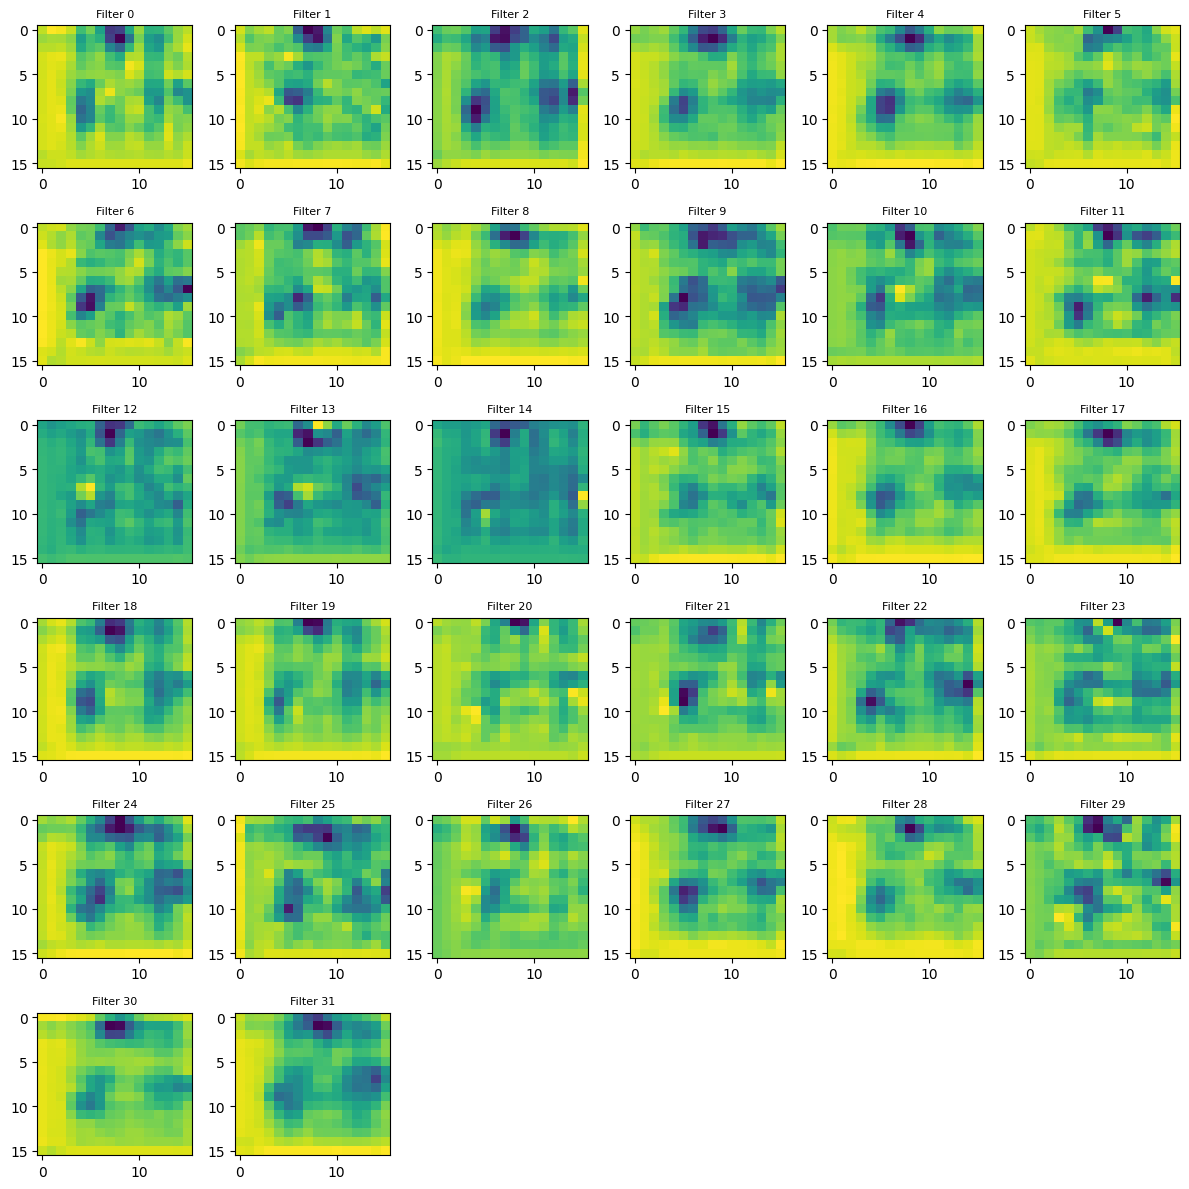

In [192]:
helpers.plot_layer_activations_dynamic_grid(normal_activations, "conv_seqs_1_res_block0_conv0")

## Exploring key interactions without goals
To discover how the agent operates without a final goal we set up an environment with no final goal present. We can then have it run through the episode as normal and look at the gif of its performance as well as the initial activations.


In [43]:
# num_levels = 5
# venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
# state = heist.state_from_venv(venv, 0)

# full_grid = state.full_grid(with_mouse=False)
# entities = state.state_vals["ents"]
# legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()


state.remove_all_entities()

x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
entities = state.state_vals["ents"]
state.set_key_position(0,x,y) 
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_mouse_pos(x,y)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()

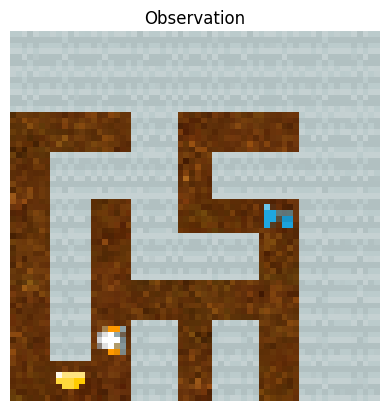

In [77]:
helpers.plot_single_observation(obs.squeeze().transpose(1,2,0))

In [68]:
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_gem_position(x,y)

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()

In [78]:
save_gif_option = True  

model = load_model()

total_reward, frames, observations = run_episode_and_save_as_gif(venv, model, filepath=f'episode_key_gem_3.gif', save_gif=save_gif_option, episode_timeout=150)

In [73]:
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]


model_activations = ModelActivations(model)

output2, normal_activations = model_activations.run_with_cache(observations[0], layer_paths)


torch.Size([64, 64, 3])


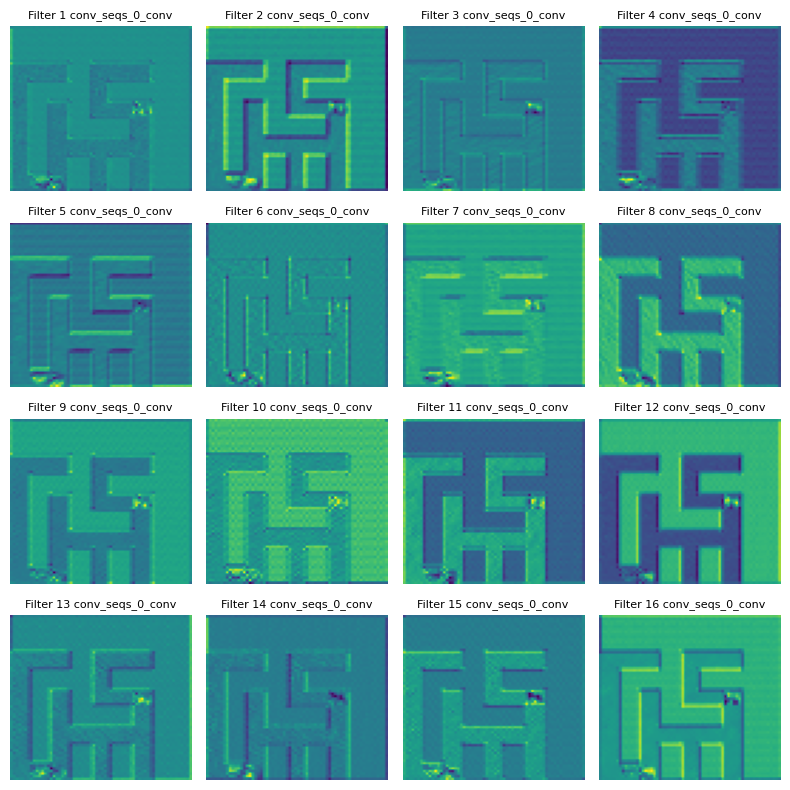

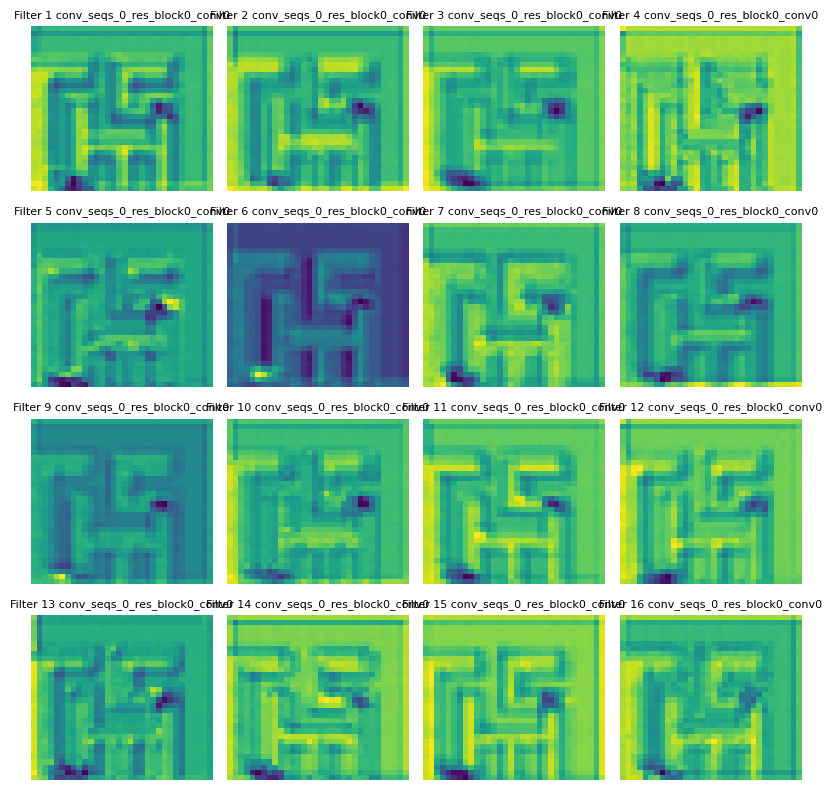

In [76]:
helpers.plot_activations_for_layers(normal_activations, ['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0'])